# test feature points
test the feature points of the roof images are stable

In [477]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [478]:
%matplotlib inline
# Makes the matplotlib plots appear inline in this jupyter notebook

In [479]:
folderPath = ""
folderPath = ""
imgName = "imageStitch_down.jpg"
# subImgName = "largeTrueSub_down.jpg"
newImage = "subImage_down.jpg"
subImgName = "subImage_down.jpg"


In [480]:
def show_image(im, name=""):
        
    h,w = im.shape[:2]
    print(name, im.shape)
    plt.imshow(im, cmap='gray')
    plt.show()

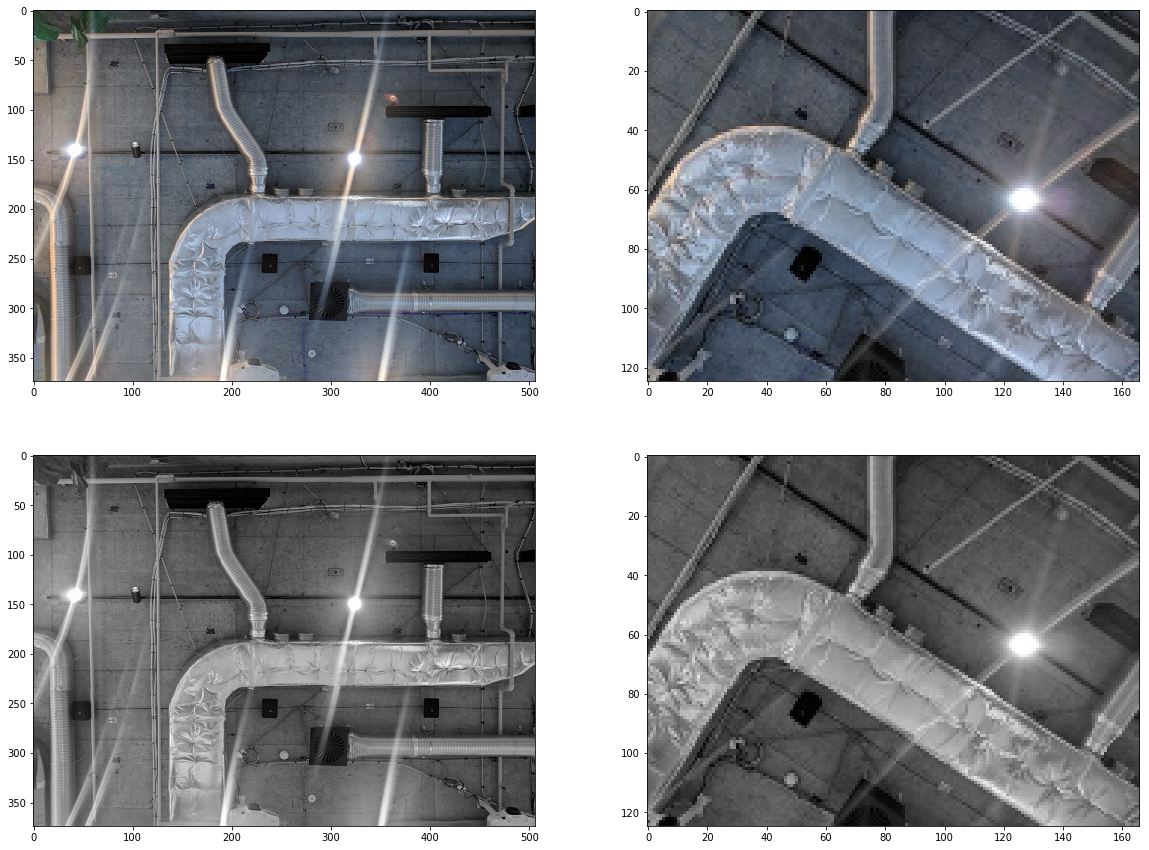

In [481]:
# resize variables
x_size, y_size = 0.5, 0.5
super_rgb   =    cv2.resize(cv2.imread(folderPath + imgName,    cv2.IMREAD_COLOR), None, fx=x_size, fy=y_size)
super_grey  =    cv2.resize(cv2.imread(folderPath + imgName,    cv2.IMREAD_GRAYSCALE), None, fx=x_size, fy=y_size)
search_rgb  =    cv2.resize(cv2.imread(folderPath + subImgName, cv2.IMREAD_COLOR), None, fx=x_size, fy=y_size)
search_grey =    cv2.resize(cv2.imread(folderPath + subImgName, cv2.IMREAD_GRAYSCALE), None, fx=x_size, fy=y_size)

plt.rcParams['figure.figsize'] = (20, 15)
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)


# fig2, ax = plt.plot(wav_t, s1)

ax1.imshow(super_rgb,cmap='gray')
ax2.imshow(search_rgb,cmap='gray')
ax3.imshow(super_grey,cmap='gray')
ax4.imshow(search_grey,cmap='gray')

# show_image(super_rgb,     "super_rgb:   Large stitched colour image")
# show_image(super_grey,    "super_grey:  Large stitched greyscale image")
# show_image(search_rgb,    "search_rgb:  Colour template image to be found")
# show_image(search_grey,   "search_grey: Greyscale template image to be found")

# show orb features in all images

ORB features were found to be not as robust as SIFT features (this is what we use later and works better)

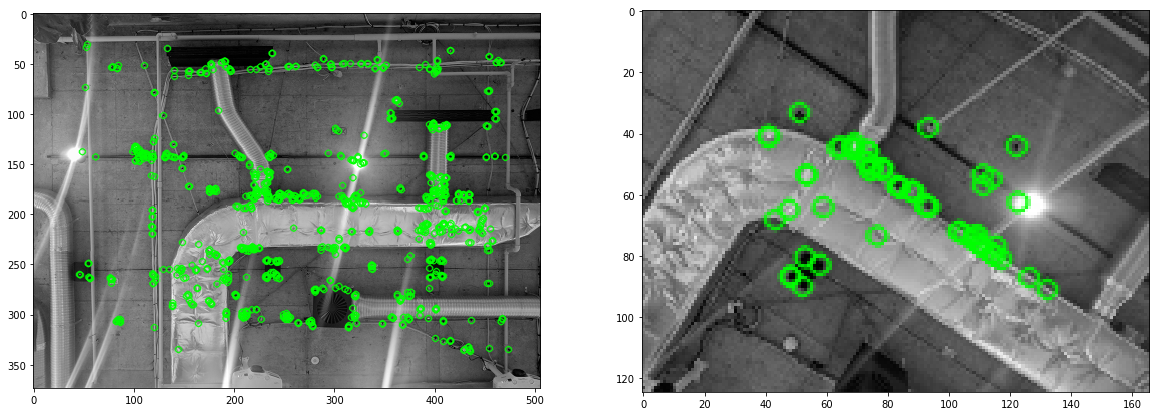

In [482]:

def add_orb(img, nfeat):
    """
    add orb features to image for showing
    """
    # Initiate ORB detector
    orb = cv2.ORB_create(nfeatures=nfeat, scoreType=cv2.ORB_FAST_SCORE)
    # find the keypoints with ORB
    kp = orb.detect(img, None)
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)
    # draw only keypoints location,not size and orientation
    img2 = cv2.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    return img2

fig1, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
im1 = add_orb(super_grey,1000)
im2 = add_orb(search_grey,100)
ax1.imshow(im1); ax2.imshow(im2)

# Try a another method call the sho-tomasi method to find some other features
again not as good

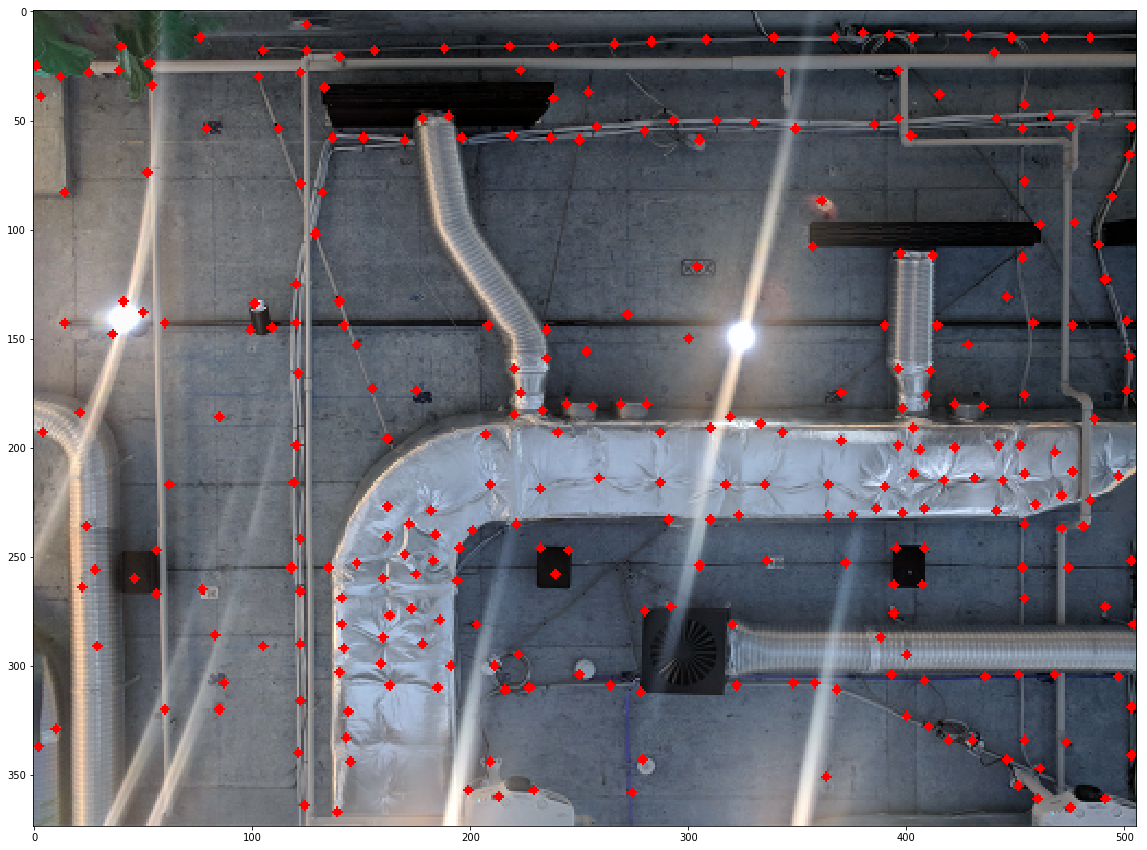

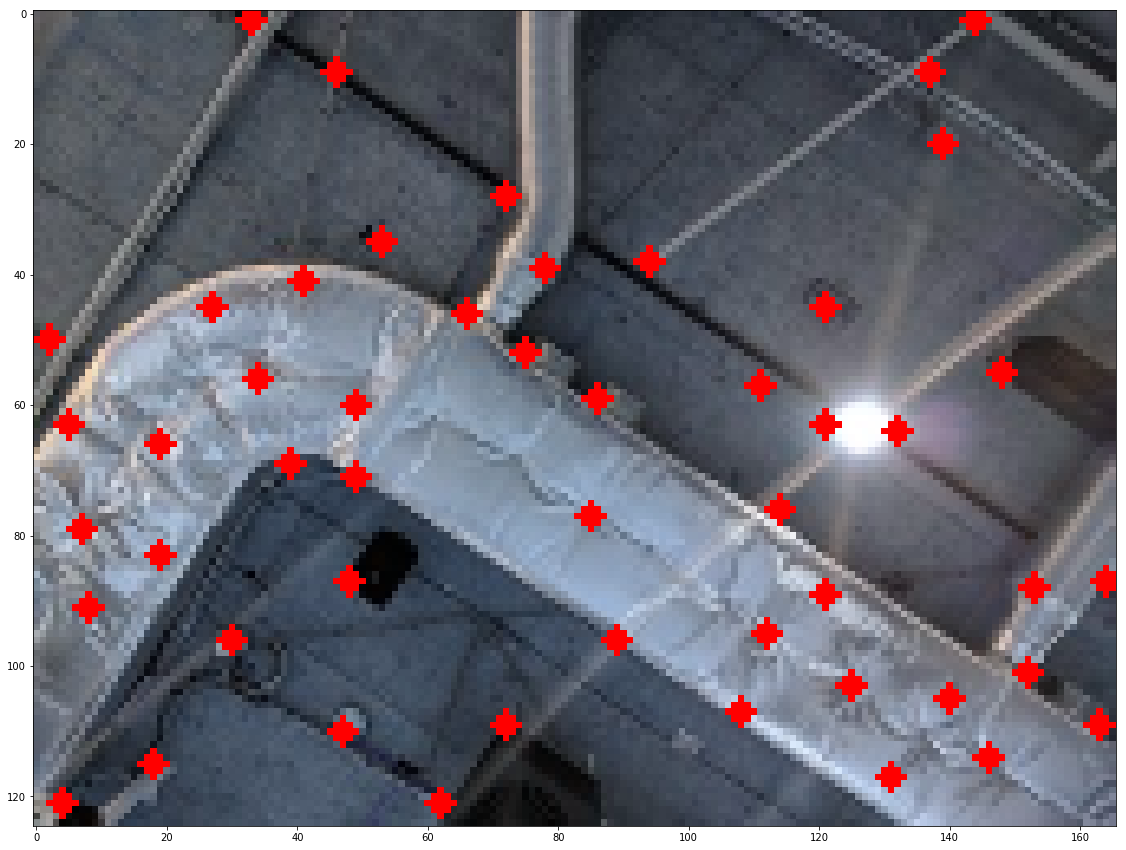

In [491]:
corners = cv2.goodFeaturesToTrack(super_grey,300,0.01,10)
corners = np.int0(corners)
img = super_rgb.copy()
# compute the descriptors with ORB
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),2,255,-1)
plt.imshow(img), plt.show()

corners = cv2.goodFeaturesToTrack(search_grey,50,0.01,10)
corners = np.int0(corners)
img = search_rgb.copy()
# compute the descriptors with ORB
for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),2,255,-1)
plt.imshow(img);

# Working Example: SIFT features and FLANN based matcher
(google FLANN and SIFT opencv and you'll see explanations 

## define a function that finds the centroid of a quadrilaeral

In [485]:
def centroid(points):
    x_coords = [p[0][0] for i, p in enumerate(points)]
    y_coords = [p[0][1] for i, p in enumerate(points)]
    _len = len(points)
    centroid_x = int(sum(x_coords)/_len)
    centroid_y = int(sum(y_coords)/_len)
    return [centroid_x, centroid_y]

In [497]:
# get the images
img1 = search_grey.copy()
img2 = super_grey.copy()

# create some contrast
b = 64.
c = 2
img1 = cv2.addWeighted(img1,1. + c/127.,img1,0, b - c)
img2 = cv2.addWeighted(img2,1. + c/127.,img2,0, b - c)

# Guassian blur the images with a window of 7x7
img1 = cv2.GaussianBlur(img1, (7,7),0)
img2 = median = cv2.GaussianBlur(img2, (7,7),0)

## Get the SIFT features

In [498]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create(nfeatures=10000)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

## Put them through the FLANN algo
kNN and tree based algorithm

In [499]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

### Print the number of features found

In [500]:
len(good)

9

## Apply homography and a perspective tranform to get the bounding "box" (quadrilateral)

In [503]:
MIN_MATCH_COUNT = 5
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#     M = np.linalg.inv(M)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    centre = tuple(centroid(np.int32(dst)))
else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

## Draw the matched features and centroid of boudning box

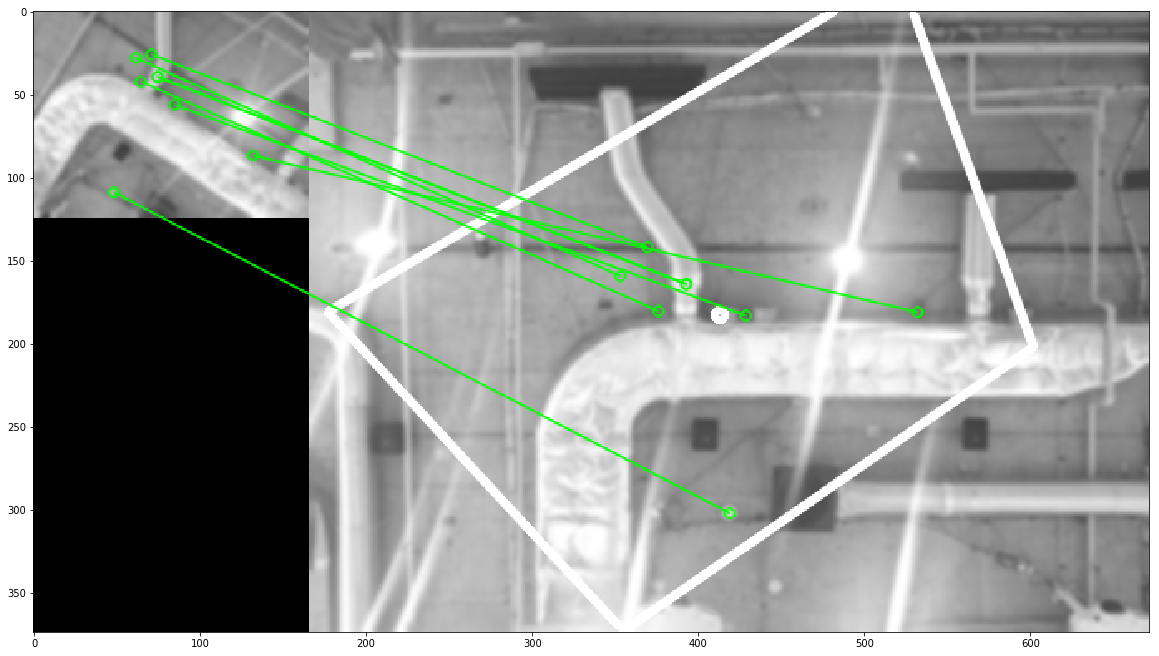

In [505]:
plt.rcParams['figure.figsize'] = (20, 15)
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

cv2.circle(img2,centre, 3,(255,0,0), 3)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)


plt.imshow(img3, 'gray');